In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [10]:
stop = set(stopwords.words('english'))
path = "sentiment_analysis/data/"
train_data_path ='sentiment_analysis/data/training_data/train.csv'

def readData(path):
    # read dictionary into df
    df_dict_data = pd.read_table(path + 'dictionary.txt')
    df_dict_prepared = df_dict_data['!|0'].str.split('|', expand=True).rename(columns={0: 'Phrase', 1: 'phrase_ids'})

    # read sentiment labels into df
    df_labels = pd.read_table(path + 'sentiment_labels.txt')
    df_labels_prepared = df_labels['phrase ids|sentiment values'].str.split('|', expand=True).rename(columns={0: 'phrase_ids', 1: 'sentiment_values'})

    #combine data frames containing sentence and sentiment
    df_all_prepared = df_dict_prepared.merge(df_labels_prepared, how='inner', on='phrase_ids')
    return df_all_prepared
    
df_all_prepared = readData(path)
training_data = pd.read_csv(train_data_path, encoding='iso-8859-1')

In [11]:
training_data.head()

,index_orig,Phrase,phrase_ids,sentiment_values
0,0,!,0,0.50000
1,1,! ',22935,0.52778
2,2,! '',18235,0.50000
3,5,! Brilliant !,40532,0.93056
4,6,! Brilliant ! ',22937,1.00000


In [12]:
# list(training_data['Phrase'][i] if  0.1 < training_data['sentiment_values'][i] < .2 else 1 for i in range(len(training_data)))

Percent of entries in range [0.5, 0.6] =  9.383 %


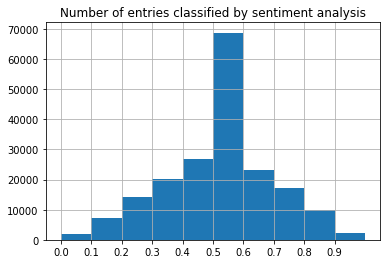

In [13]:
fig,ax = plt.subplots(1,1)
training_data.hist(column = 'sentiment_values', ax = ax)
ax.set_title('Number of entries classified by sentiment analysis')
ax.set_xticks([i/10 for i in range(0,10)])
print('Percent of entries in range [0.5, 0.6] =  %.3f %%'%(100*(sum(list(filter(lambda x: 0.5 < x < 0.6, training_data['sentiment_values'])))/len(training_data))))

First we read in the embeddings file into a dictionary - each entry is a word, followed by the vector of numbers to represent its values

In [115]:
embeddings_index = {}
f = open(path + '/glovo/glove_6B/glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [117]:
# example of the word representation in terms of vector
embeddings_index[','][:5]

array([-0.25539 , -0.25723 ,  0.13169 , -0.042688,  0.21817 ],
      dtype=float32)

In [161]:
import re

def clearWords(lines_without_stopwords, training_data, col_name="Phrase"):
    for line in training_data[col_name].values:
        line = line.lower()
        line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE)
        line_no_stps = list(filter(lambda word: word not in stop, line_by_words))
        lines_without_stopwords.append(line_no_stps)
    
lines_without_stopwords=[]
clearWords(lines_without_stopwords, training_data)

In [166]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
lines_without_stopwords = list(filter(lambda el:el != [], lines_without_stopwords))
tokenizer.fit_on_texts(lines_without_stopwords)
sequences = tokenizer.texts_to_sequences(lines_without_stopwords) # set numbers to the words
print()
word_index = tokenizer.word_index # create index for each word
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # zero matrix

labels = to_categorical(np.asarray([round(i*10) if round(i*10) != 10 else 9 for i in training_data['sentiment_values']]), num_classes=10, dtype='float32')
print(data.shape)
print(labels.shape)


Found 17927 unique tokens.
(190115, 100)
(191646, 10)


In [167]:
print(sequences[:10])
print(lines_without_stopwords[:10])

[[559], [559], [], [83], [], [402], [361, 46, 207, 542], [], [], []]
[['brilliant'], ['brilliant'], ['c', 'mon'], ['gollum', 'performance', 'incredible'], ['romething'], ['run'], ['camera', 'twirls', 'oh', 'look', 'clever', 'angle', 'wow', 'jump', 'cut'], ['wow'], ['zoom'], ['8217']]


#### Form matrix word - its vector

In [119]:
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(1001, 300)


Text(0.5, 1.0, 'example vectors')

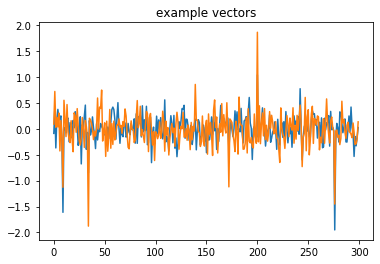

In [120]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[word_index.get('probably')]) # 0.5 - sent analysis - blue
plt.plot(embedding_matrix[word_index.get('best')]) # 0.9-1 - sent analysis - orange
# plt.plot(embedding_matrix[word_index.get('invited')]) # 0.1-0.2 - sent analysis - green
plt.title('example vectors')

#### Here we can see the notation from where we have the values in emb_matrix

In [ ]:
# print(word_index.get('invited'))
# print(embeddings_index['invited'][:5])
# print(embedding_matrix[6128][:5])

In [13]:
## To create and visualize a model

from keras.models import Sequential
from keras.layers import Dense, Bidirectional, Dropout, LSTM

In [ ]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=100, trainable=False))

model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(10, activation='softmax'))
# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
print(labels.shape)
model.fit(data, np.array(labels), validation_split=0.1, epochs = 1)

In [ ]:
from sklearn.manifold import TSNE
## Get weights
embds = model.layers[0].get_weights()[0]
## Plotting function
## Visualize words in two dimensions 
tsne_embds = TSNE(n_components=2).fit_transform(embds)

plt.plot(tsne_embds[:,0],tsne_embds[:,1],'.')

In [ ]:
# model.save(path + 'my_model.h5')

### To run the following steps we don't have to train the model
- load the model

In [5]:
from keras.models import load_model
model = load_model(path + 'my_model.h5')

Using TensorFlow backend.


In [185]:
# print(model.summary())
# model.predict([100, 100])

#### Sentiment analysis per essay

designed the model to provide a sentiment score between 0 to 1 with 0 being very negative and 1 being very positive. This was done by building a multi-class classification model i.e 10 class, one class for each decile.

In [189]:
def clearByDividerWords(lines_without_stopwords, training_data, div, col_name="Phrase"):
    for line in training_data[col_name].values:
        for div_part in line.split(div):
            div_part = div_part.lower()
            div_part_by_words = re.findall(r'(?:\w+)', sent, flags = re.UNICODE)
            div_part_no_stps = list(filter(lambda word: word not in stop, div_part_by_words))
            div_part_without_stopwords.append(div_part_no_stps)

def generate_essay_data_sentiment_matrix(filename):
    project_data_path = 'essayVSreview/'

    opened_filename = pd.read_csv(project_data_path + filename, sep='\t')
    opened_filename_without_stops = []
    
    # whole essay
    clearWords(opened_filename_without_stops, opened_filename, 'ReviewText')
    print(opened_filename_without_stops[5])
    opened_filename_without_stops = list(filter(lambda el:el != [], opened_filename_without_stops))
    sequences_opened_filename = tokenizer.texts_to_sequences(opened_filename_without_stops)
    print(sequences_opened_filename[5])
    data_opened_filename = pad_sequences(sequences_opened_filename, maxlen=MAX_SEQUENCE_LENGTH) # zero matrix
    print(data_opened_filename[5])
    pred_essay = model.predict(data_opened_filename)
    print(pred_essay[5])
    return pred_essay

a = generate_essay_data_sentiment_matrix('GayMarriage_400.csv')

['gay', 'marriage', 'right', 'people', 'people', 'please', 'long', 'interfere', 'way', 'people', 'living', 'lives', 'one', 'life', 'appropriate', 'cast', 'judgement', 'people', 'especially', 'know', 'anything', 'circumstances', 'think', 'gay', 'people', 'able', 'marry', 'really', 'care', 'many', 'loveless', 'straight', 'marriages', 'think', 'fine', 'two', 'people', 'actually', 'care', 'married', 'would', 'fine', 'extending', 'normal', 'economic', 'benefits', 'well']
[697, 87, 37, 37, 42, 16, 37, 593, 249, 4, 14, 72, 37, 276, 136, 170, 151, 697, 37, 632, 55, 160, 39, 514, 151, 319, 32, 37, 194, 160, 25, 319, 15]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 697  87  37  37  42
  16  37 593 249   4  14  72  37 276 136 170 151 697  37 632  55 160  39
 514 151 319  32

In [178]:
arr = []
for i in range(len(a)):
    arr.append(sum(a[i])/len(a[i]))
arr

[0.10000000428408384,
 0.09999999908031895,
 0.10000000428408384,
 0.09999999908031895,
 0.09999999501815182,
 0.10000000358559191,
 0.1000000025742338,
 0.10000000358559191,
 0.10000000158324837,
 0.09999999739229679,
 0.10000000158324837,
 0.09999999739229679,
 0.09999999694991857,
 0.0999999949708581,
 0.09999999694991857,
 0.10000001261942089,
 0.1000000024214387,
 0.10000000002037268,
 0.1000000043422915,
 0.10000000419095159,
 0.09999999022111297,
 0.10000000330619514,
 0.10000000330619514,
 0.09999999022111297,
 0.10000000642612576,
 0.09999999264255166,
 0.09999999264255166,
 0.10000000642612576,
 0.10000000279396773,
 0.09999999841675163,
 0.09999999832361936,
 0.10000000167638064,
 0.1000000003259629,
 0.10000000023283065,
 0.1000000003259629,
 0.10000000158324837,
 0.1000000037252903,
 0.10000000009313226,
 0.1000000037252903,
 0.10000000041909515,
 0.10000000856816768,
 0.10000000006984919,
 0.10000000856816768,
 0.10000000622821972,
 0.10000000540167094,
 0.099999996647238

In [171]:
pred_essay_gay_merriage = generate_essay_data_sentiment_matrix('GayMarriage_400.csv')
pred_essay_gun_control = generate_essay_data_sentiment_matrix('GunControl_400.csv')
pred_essay_review_amt = generate_essay_data_sentiment_matrix('ReviewAMT_500_t.csv')

In [113]:
pred_essay_gay_merriage

array([[6.79059699e-03, 4.97662760e-02, 1.49787962e-01, ...,
        1.06017075e-01, 8.81921053e-02, 2.07485836e-02],
       [2.86190421e-04, 4.95696766e-03, 2.67686211e-02, ...,
        1.97151572e-01, 3.41092497e-01, 1.64954945e-01],
       [6.79059699e-03, 4.97662760e-02, 1.49787962e-01, ...,
        1.06017075e-01, 8.81921053e-02, 2.07485836e-02],
       ...,
       [7.01924041e-03, 4.12457474e-02, 1.21828392e-01, ...,
        1.34134188e-01, 1.30043387e-01, 3.92316952e-02],
       [7.01924181e-03, 4.12457474e-02, 1.21828407e-01, ...,
        1.34134188e-01, 1.30043387e-01, 3.92316990e-02],
       [3.32234195e-03, 2.73395162e-02, 7.03624785e-02, ...,
        1.27256617e-01, 1.25540316e-01, 4.15765382e-02]], dtype=float32)

ONE COLUMN: \
each_row_gay_sent_av //xxx\
each_row_gun_sent_av\
each_row_review_sent_av\
each_row_truthfulnes\


In [227]:
each_row_gay_sent_av = []
for i in range(1600):
    row_sentiments = pred_essay_gay_merriage[i]
    row_class = np.where(row_sentiments==max(row_sentiments))
    each_row_gay_sent_av.append(row_class[0][0])

In [228]:
each_row_gay_sent_av

[4,
 8,
 4,
 8,
 7,
 8,
 7,
 8,
 4,
 2,
 4,
 2,
 8,
 2,
 8,
 2,
 2,
 8,
 8,
 2,
 2,
 7,
 7,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 8,
 2,
 8,
 4,
 8,
 4,
 2,
 4,
 2,
 4,
 8,
 8,
 8,
 8,
 4,
 2,
 2,
 4,
 8,
 2,
 8,
 2,
 4,
 4,
 4,
 4,
 4,
 8,
 4,
 8,
 8,
 8,
 8,
 8,
 2,
 2,
 2,
 2,
 8,
 8,
 8,
 8,
 2,
 2,
 2,
 2,
 6,
 4,
 4,
 6,
 2,
 8,
 2,
 8,
 2,
 6,
 2,
 6,
 8,
 2,
 2,
 8,
 8,
 2,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 5,
 5,
 8,
 8,
 8,
 8,
 8,
 7,
 8,
 8,
 7,
 8,
 2,
 8,
 2,
 6,
 4,
 4,
 8,
 2,
 8,
 8,
 2,
 4,
 2,
 2,
 4,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 8,
 4,
 4,
 8,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 8,
 2,
 8,
 2,
 8,
 2,
 2,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 8,
 2,
 8,
 2,
 4,
 4,
 2,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 2,
 5,
 2,
 5,
 2,
 2,
 5,
 2,
 5,
 8,
 8,
 8,
 8,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 2,
 5,
 4,
 5,
 4,
 4,
 8,
 4,
 8,
 2,
 2,
 2,
 2,
 2,
 8,
 8,
 2,
 2,
 2,
 2,
 2,
 6,
 4,
 4,
 6,
 2,
 7,
 2,
 7,
 2,
 2,
 2,
 2,
 7,
 2,
 2,
 7,
 4,
 2,


In [230]:
each_row_gun_sent_av = []
for i in range(len(pred_essay_gun_control)):
    row_sentiments = pred_essay_gun_control[i]
    row_class = np.where(row_sentiments==max(row_sentiments))
    each_row_gun_sent_av.append(row_class[0][0])

In [229]:
each_row_review_sent_av = []
for i in range(1600):
    row_sentiments = pred_essay_review_amt[i]
    row_class = np.where(row_sentiments==max(row_sentiments))
    each_row_review_sent_av.append(row_class[0][0])

In [96]:
each_row_truthfulnes = []
for _ in range(400):
    each_row_truthfulnes += ['True', 'Fake', 'Fake', 'True']

In [97]:
# sum(each_row_av)/len(each_row_av)
len(each_row_truthfulnes)

1600

[2.8619042e-04 4.9569677e-03 2.6768621e-02 3.6356527e-02 5.2459557e-02
 5.8646534e-02 1.1732658e-01 1.9715157e-01 3.4109250e-01 1.6495495e-01]


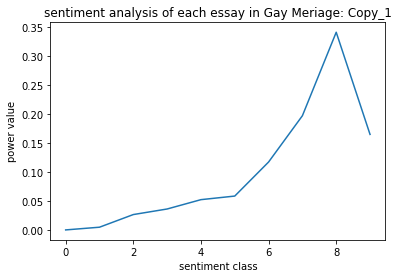

[0.00332234 0.02733952 0.07036248 0.1011386  0.1375879  0.198946
 0.16692968 0.12725662 0.12554032 0.04157654]


In [197]:
# sentiment analysis of each essay in gay_merriage
def show_each_essay_sentiment(pred, file, task, task_desc):
#     for i in range(task, 1600, 4):
    print(pred[1])
    plt.plot(pred[1])
    plt.title('sentiment analysis of each essay in ' + file + ": " + task_desc)
    plt.xlabel('sentiment class')
    plt.ylabel('power value')
    plt.show()
    
copy1, copy2, true, fake = 0, 1, 2, 3
copy_1_desc, copy_2_desc, true_desc, fake_desc = "Copy_1", "Copy2", "True Essay", "Fake Essay"
show_each_essay_sentiment(pred_essay_gay_merriage, 'Gay Meriage', copy1, copy_1_desc)
print(pred_essay_gay_merriage[1599])
# show_each_essay_sentiment(pred_essay_gay_merriage, 'Gay Meriage', copy2, copy_2_desc)
# show_each_essay_sentiment(pred_essay_gay_merriage, 'Gay Meriage', true, true_desc)
# show_each_essay_sentiment(pred_essay_gay_merriage, 'Gay Meriage', fake, fake_desc)

# show_each_essay_sentiment(pred_essay_gun_control, 'Gun Control', copy1, copy_1_desc)
# show_each_essay_sentiment(pred_essay_gun_control, 'Gun Control', copy2, copy_2_desc)
# show_each_essay_sentiment(pred_essay_gun_control, 'Gun Control', true, true_desc)
# show_each_essay_sentiment(pred_essay_gun_control, 'Gun Control', fake, fake_desc)

# show_each_essay_sentiment(pred_essay_review_amt, 'Review AMT', copy2, copy_2_desc)
# show_each_essay_sentiment(pred_essay_review_amt, 'Review AMT', copy1, copy_1_desc)
# show_each_essay_sentiment(pred_essay_review_amt, 'Review AMT', true, true_desc)
# show_each_essay_sentiment(pred_essay_review_amt, 'Review AMT', fake, fake_desc)

##### Conclusion:
For each file we have as positive thoughts as negative.

For review esaays it's much esaier to write narrow-minded sentances, so we can see no doubts in the midle of the plots.

#### Sentiment analysis per sentance

In [ ]:
def clearByDividerWords (lines_without_stopwords, training_data, div, col_name="Phrase"):
    # by row
    for line in training_data[col_name].values:
        div_part_without_stopwords = []
        for div_part in line.split(div):
            div_part = " ".join([i.lower() for i in div_part])
            div_part_by_words = re.findall(r'(?:\w+)', div_part, flags = re.UNICODE)
            div_part_no_stps = list(filter(lambda word: word not in stop, div_part_by_words))
            div_part_without_stopwords.append(div_part_no_stps)
        lines_without_stopwords.append(div_part_without_stopwords)
            

def generate_sent_data_sentiment_matrix(filename):
    project_data_path = 'essayVSreview/'
    opened_filename = pd.read_csv(project_data_path + filename, sep='\t')
    opened_filename.head()
    opened_filename_without_stops = []

    pred_essay = []
    clearByDividerWords(opened_filename_without_stops, gay_merriage, '.', 'ReviewText')
    for sent_without_stops in opened_filename_without_stops:
        sequences_sent = tokenizer.texts_to_sequences(sent_without_stops)
        sent_matrix = pad_sequences(sequences_sent, maxlen=MAX_SEQUENCE_LENGTH) # zero matrix
        pred_essay.append(model.predict(sent_matrix))
    return pred_essay

In [ ]:
pred_sent_gay_merriage = generate_sent_data_sentiment_matrix('GayMarriage_400.csv')
pred_sent_gun_control = generate_sent_data_sentiment_matrix('GunControl_400.csv')
pred_sent_review_amt = generate_sent_data_sentiment_matrix('ReviewAMT_500_t.csv')

#### Example of sentance sentiment analysis

In [ ]:
# sentiment analysis of each sentance in review_amt first essay
plt.figure()
for i in range(len(pred_sent_review_amt[:5])):
    for j in range(len(pred_sent_review_amt[i])):
        plt.plot(pred_sent_review_amt[i][j])
    plt.title('sentiment analysis of each sentance in review_amt first essay')
    plt.xlabel('sentiment class')
    plt.ylabel('power value')
    plt.show()

#### Conclusions:
Each sentance consist of a big amount of neutral words.

### KeyStroke Analysis

In [38]:
from collections import defaultdict
proj_data_path = 'essayVSreview/'

gay_merriage = pd.DataFrame(pd.read_csv(proj_data_path +"GayMarriage_400.csv", sep='\t'))
gun_control = pd.DataFrame(pd.read_csv(proj_data_path + "GunControl_400.csv", sep='\t'))
review_amt = pd.DataFrame(pd.read_csv(proj_data_path +"ReviewAMT_500_t.csv", sep='\t'))
files = [gay_merriage, gun_control, review_amt]
files_names = ['gay_merriage', 'gun_control', 'review_amt']

In [46]:
SPACE = 32
PERIOD = 190
def find_average_writing_pause(file, filename, divider):
    '''
    return: list(dict(hundrets: num_of_cases))
    '''
    res = []
    f_ind = file.index
    for id_ in range(1600):
        row_meta = file['ReviewMeta'][id_].split(';')
        row_timestamp = []
        row_keycode = []
        for sep_meta in row_meta:
            if len(sep_meta.split()) < 3:
                continue
            row_int_timestamp = int(sep_meta.split()[0])
            row_int_keycode = int(sep_meta.split()[2])
            row_timestamp.append(row_int_timestamp)
            row_keycode.append(row_int_keycode)
        timestamp_diff = []
        first = 0
        for timestamp_i in range(1, len(row_timestamp)):
            # pauses between words
            # if we remove this line we'll get letters distribution
            if row_keycode[timestamp_i] == divider:
                timestamp_diff.append(row_timestamp[timestamp_i] - row_timestamp[first])
            first = timestamp_i
        dict_ = defaultdict(int)
        for i in timestamp_diff:
            if not (0 < i < 250):
                continue
            dict_[round(i/10) * 10] += 1
        res.append(dict_)
    return res

NameError: name 'res' is not defined

In [34]:
def draw_plot(divider, task, title):
    # plot of the biggest number of cases
    fig, axs = plt.subplots(3, figsize=[18.5, 10.5])
    fig.suptitle(title)
    for i in range(len(files)):
        file = files[i]
        if i == 2 and task == 'True Essay':
            task = 'True Review'
        if i == 2 and task == 'Fake Essay':
            task = 'Fake Review'
        list_of_essay_pauses = find_average_writing_pause(file, files_names[i], divider)
        print(list_of_essay_pauses[:10])
        for dict_ in list_of_essay_pauses:
            try:
                lists = sorted(dict_.items())
                x, y = zip(*lists)
                axs[i].plot(x, y)
                axs[i].set(ylabel='number of pause cases in ' + files_names[i])
            except ValueError:
                continue

    for ax in axs.flat:
        ax.set(xlabel='timestamp pauses btw words')

In [58]:
for i in range(len(files)):
    file = files[i]
    if i == 0:
        gay_words_pauses = find_average_writing_pause(file, files_names[i], SPACE)
    elif i == 1:
        gun_words_pauses = find_average_writing_pause(file, files_names[i], SPACE)
    elif i == 2:
        review_words_pauses = find_average_writing_pause(file, files_names[i], SPACE)

each_row_gay_sent_av //xxx\
each_row_gun_sent_av\
each_row_review_sent_av\
each_row_truthfulnes\
gay_essay_num_words_list \\xxx\
gun_essay_num_words_list\
amt_essay_num_words_list

In [84]:
# fill arrays
gay_essay_num_words_list = []
for gay_essay in gay_words_pauses:
    ouliers = 0
    lst = []
    for i in range(10, 180, 10):
        lst.append(gay_essay[i])
    for val in gay_essay.keys():
        if val > 150:
            ouliers += gay_essay[val]
    lst.append(ouliers)
    gay_essay_num_words_list.append(lst)

In [83]:
# fill arrays
gun_essay_num_words_list = []
for gun_essay in gun_words_pauses:
    ouliers = 0
    lst = []
    for i in range(10, 180, 10):
        lst.append(gun_essay[i])
    for val in gun_essay.keys():
        if val > 150:
            ouliers += gun_essay[val]
    lst.append(ouliers)
    gun_essay_num_words_list.append(lst)

In [82]:
# fill arrays
amt_essay_num_words_list = []
for amt_essay in review_words_pauses:
    ouliers = 0
    lst = []
    for i in range(10, 180, 10):
        lst.append(amt_essay[i])
    for val in amt_essay.keys():
        if val > 150:
            ouliers += amt_essay[val]
    lst.append(ouliers)
    amt_essay_num_words_list.append(lst)

In [237]:
import csv

with open('dataLA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ',
                            quotechar=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'name']+['keystroke' + str(i) for i in range(10, 180, 10)] + ['ouliers', 'essay_sent', 'essay_type'])
    for i in range(1600):
        writer.writerow([str(i), 'GayMerriage']+[str(keystr) for keystr in gay_essay_num_words_list[i]]+[str(each_row_gay_sent_av[i]), each_row_truthfulnes[i]])
        
    for id_ in range(1600, 1600*2):
        i = id_ - 1600
        writer.writerow([str(id_), 'GunControl']+[str(keystr) for keystr in gun_essay_num_words_list[i]]+[str(each_row_gun_sent_av[i]), each_row_truthfulnes[i]])
        
    for id_ in range(1600*2, 1600*3):
        i = id_ - 1600*2
        writer.writerow([str(id_), 'ReviewAMT']+[str(keystr) for keystr in amt_essay_num_words_list[i]]+[str(each_row_review_sent_av[i]), each_row_truthfulnes[i]])
        

In [87]:
keystrokes = ['keystroke' + str(i) for i in range(10, 180, 10)]


[defaultdict(<class 'int'>, {60: 73, 80: 73, 100: 28, 160: 14, 240: 6, 110: 12, 210: 14, 140: 13, 50: 11, 130: 11, 180: 5, 220: 8, 190: 8, 230: 2, 200: 1, 70: 1, 30: 1, 170: 2, 120: 2, 0: 1, 20: 1}), defaultdict(<class 'int'>, {40: 19, 90: 24, 30: 9, 50: 17, 100: 15, 20: 16, 80: 28, 110: 6, 60: 35, 70: 30, 10: 26, 120: 2, 130: 1, 160: 1, 140: 1}), defaultdict(<class 'int'>, {20: 10, 70: 49, 130: 7, 30: 12, 40: 13, 100: 6, 50: 15, 180: 2, 90: 5, 80: 32, 60: 41, 140: 4, 10: 7, 120: 5, 170: 4, 110: 2, 190: 4, 160: 5, 200: 2, 210: 1, 150: 2}), defaultdict(<class 'int'>, {90: 16, 100: 18, 80: 35, 130: 10, 110: 10, 60: 24, 50: 23, 170: 2, 30: 20, 70: 18, 120: 16, 10: 18, 40: 20, 150: 4, 20: 38, 140: 11, 0: 5, 180: 2, 160: 4, 190: 1}), defaultdict(<class 'int'>, {110: 25, 100: 23, 140: 28, 120: 35, 150: 11, 80: 11, 70: 11, 50: 12, 200: 1, 130: 30, 170: 8, 160: 5, 90: 13, 40: 10, 180: 1, 240: 2, 60: 14, 190: 2, 30: 5, 20: 2, 210: 2, 230: 3, 220: 1, 10: 1}), defaultdict(<class 'int'>, {20: 28, 

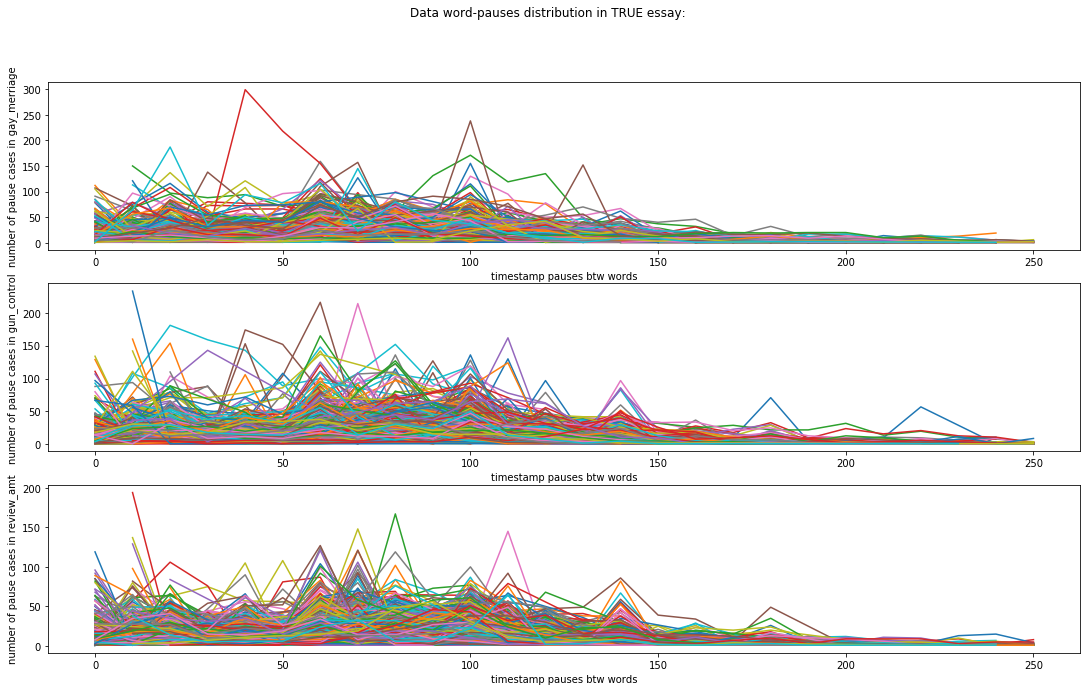

In [39]:
# True essays words distribution
draw_plot(SPACE, 'True Essay', 'Data word-pauses distribution in TRUE essay:')
# Fake essays words distribution
# draw_plot(SPACE, 'Fake Essay', 'Data word-pauses distribution in FAKE essay:')
# # Copy True essays words distribution
# draw_plot(SPACE, 'Copy_1', 'Data word-pauses distribution in Copy of TRUE essay:')
# # Copy Fake essays words distribution
# draw_plot(SPACE, 'Copy_1', 'Data word-pauses distribution in Copy of FAKE essay:')
# TODO: draw density function

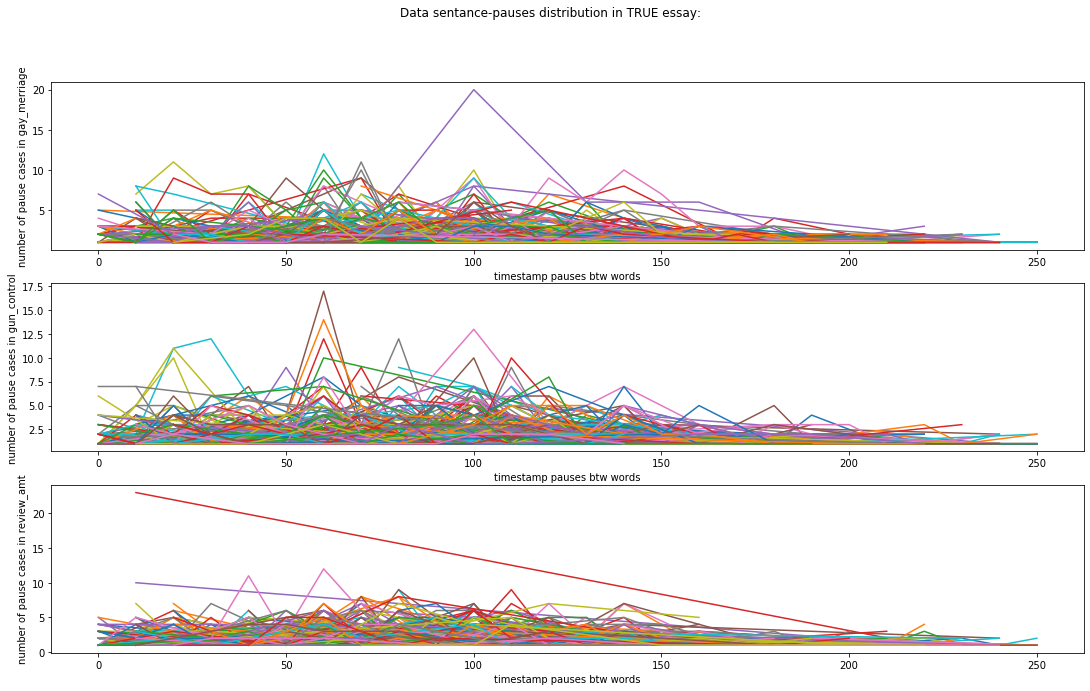

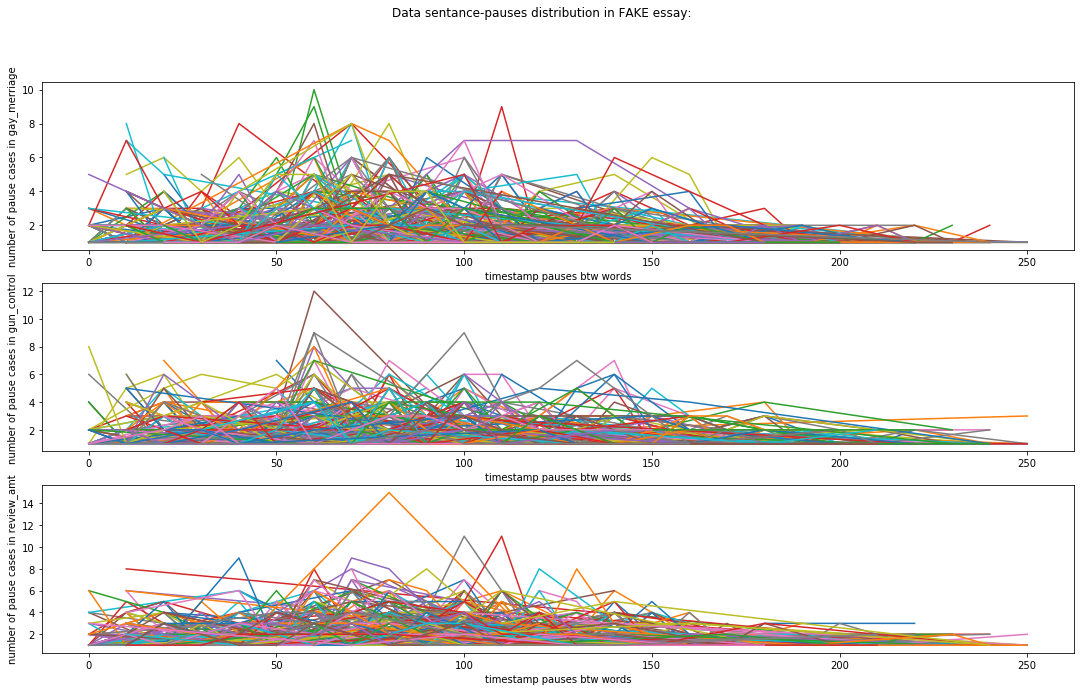

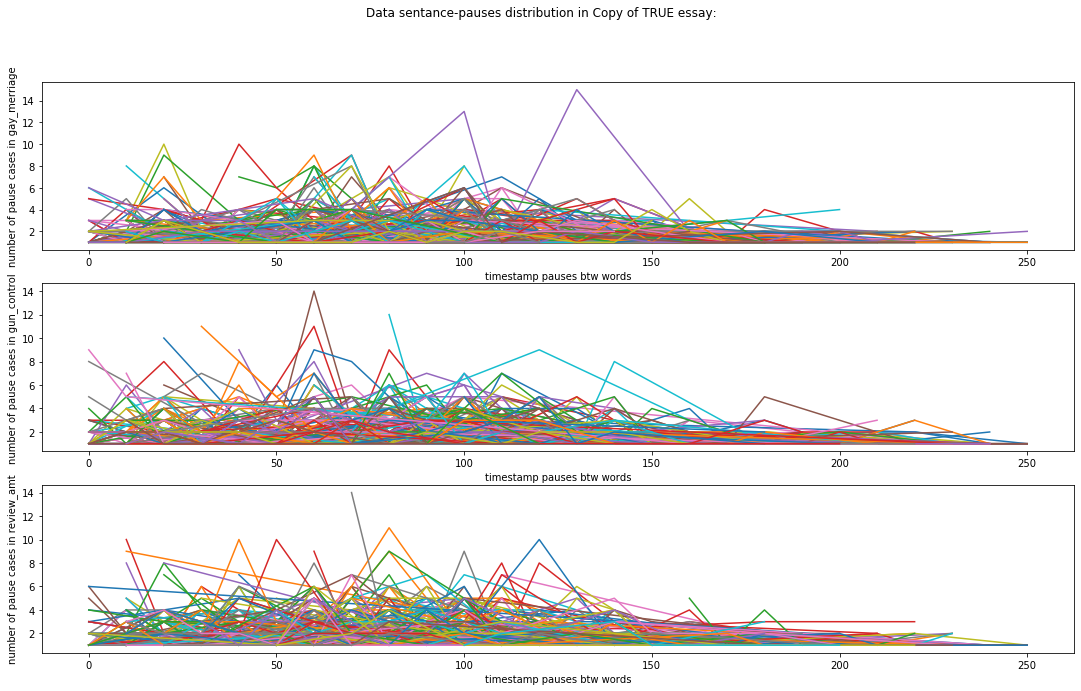

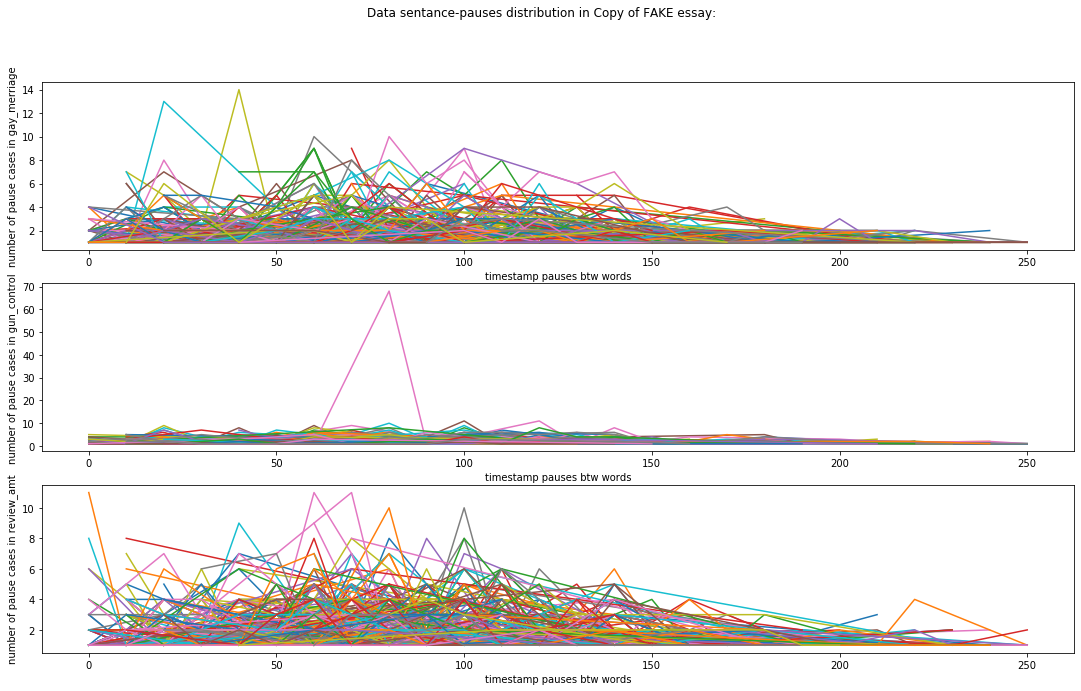

In [493]:
# True essays sentance distribution
draw_plot(PERIOD, 'True Essay', 'Data sentance-pauses distribution in TRUE essay:')
# Fake essays sentance distribution
draw_plot(PERIOD, 'Fake Essay', 'Data sentance-pauses distribution in FAKE essay:')
# Copy True essays sentance distribution
draw_plot(PERIOD, 'Copy_1', 'Data sentance-pauses distribution in Copy of TRUE essay:')
# Copy Fake essays sentance distribution
draw_plot(PERIOD, 'Copy_2', 'Data sentance-pauses distribution in Copy of FAKE essay:')
# TODO: draw density function

As we can see the most average pause:
- between letters is 100 miliseconds.
- between words is from 0 to 150
- between sentances is from 25 to 125

### TRASH is below

In [296]:
PERIOD = '190'
ARROWS = [37, 38, 39, 40]
BACKSPACE = 8

SENT_AV_TOP_LIM = 125
SENT_AV_BOTTOM_LIM = 25
def analise_sentance_keystroke(file):
    '''
    list of dictionaries with each file (by sentance) analysis
    return: list(dict('trueEssay': dict('MouseUp', 'Freq'...), 'falseEssay': dict('MouseUp', 'Freq'...)))
    '''
    f_indx = file.index
    sentence_keystroke_true = []
    sentence_keystroke_false = []
    each_sent_res = []
    last_timestamp = 0
    i_end = 0
    
    # each row-essay in a file 
    for id in range(f_indx.start, 1600):
        key_down_freq = []

        keystroke_meta_data = gay_merriage['ReviewMeta'][id].split(';')
        i_start = i_end
        if i_start >= len(keystroke_meta_data):
            continue
        row_meta = keystroke_meta_data[i_start]
        
        if file['Task'][id] in ['Copy_1', 'True Essay']:
            sent_keystroke_data = sentence_keystroke_true
        else:
            sent_keystroke_data = sentence_keystroke_false
        
        while len(row_meta.split()) >= 2 and row_meta.split()[2] != PERIOD:
            i_end += 1
            row_meta = keystroke_meta_data[i_end]
        for sent_event in keystroke_meta_data[i_start:i_end]:
            sent_keystroke_data_dict = defaultdict(int)
            meta_sent_parser = sent_event.split()
            event = meta_sent_parser[1]

            # collect KeyStroke date out of the sentence
            cur_timestamp = int(meta_sent_parser[0])
            timestamp_diff = cur_timestamp - last_timestamp
            
            # choose only 'special' data
            if timestamp_diff > SENT_AV_TOP_LIM or \
                timestamp_diff < SENT_AV_BOTTOM_LIM:
                key_down_freq.append(timestamp_diff)
            last_timestamp = cur_timestamp
            
            if event == 'MouseUp':
                sent_keystroke_data_dict['mouse_select'] += int(meta_sent_parser[3]) - int(meta_sent_parser[2])
            elif int(meta_sent_parser[2]) in ARROWS:
                sent_keystroke_data_dict['arrows'] += 1
            elif int(meta_sent_parser[2]) == BACKSPACE:
                sent_keystroke_data_dict['del'] += 1
            sent_keystroke_data_dict['key_down_freq'] = key_down_freq
            # list of each sentance analysises
            sent_keystroke_data.append(sent_keystroke_data_dict)
        essay_res_with_list_of_sent = {'trueEssay': sentence_keystroke_true, 'falseEssay': sentence_keystroke_false}
        each_sent_res.append(essay_res_with_list_of_sent)
    return each_sent_res

In [297]:
dict_of_gayMeraige_sent_keystroke = analise_sentance_keystroke(files[0])
dict_of_gunControl_sent_keystroke = analise_sentance_keystroke(files[1])
dict_of_reviewAMT_sent_keystroke = analise_sentance_keystroke(files[2])

In [422]:
len(dict_of_gayMeraige_sent_keystroke)

35

In [459]:
WORDS_AV_TOP_LIM = 0
WORDS_AV_BOTTOM_LIM = 150

def analise_essay_keystroke(file):
    file_ind = file.index
    dict_true = defaultdict(int)
    dict_false = defaultdict(int)
    key_down_freq = []
    last_timestamp = 0
    res= []
    
    for id in range(file_ind.start, file_ind.stop, file_ind.step):
        dict_to_write = dict_true if file['Task'][id] in ['Copy_1', 'True Essay'] else dict_false
        keystroke_meta_data = file['ReviewMeta'][id].split(';')
        
        for i in range(len(keystroke_meta_data)):
            meta_essay_parser = keystroke_meta_data[i].split()
            if (len(meta_essay_parser) < 2):
                continue
            event = meta_essay_parser[1]
            
            # collect KeyStroke date out of the sentence
            cur_timestamp = int(meta_essay_parser[0])
            timestamp_diff = cur_timestamp - last_timestamp
            
            # choose only 'special' data
            if timestamp_diff > WORDS_AV_TOP_LIM or \
                timestamp_diff < WORDS_AV_BOTTOM_LIM:
                if timestamp_diff < 0:
                    cur_timestamp = last_timestamp
                    timestamp_diff = cur_timestamp - last_timestamp
                key_down_freq.append(timestamp_diff)
            last_timestamp = cur_timestamp
            
            if event == 'MouseUp':
                dict_to_write['mouse_select'] += int(meta_essay_parser[3]) - int(meta_essay_parser[2])
            elif int(meta_essay_parser[2]) in ARROWS:
                dict_to_write['arrows'] += 1
            elif int(meta_essay_parser[2]) == BACKSPACE:
                dict_to_write['del'] += 1
            dict_to_write['key_down_freq'] = key_down_freq
            dict_ = defaultdict(int)
            for i in timestamp_diff:
                if not (0 < i < 250):
                    continue
                dict_[round(i/10) * 10] += 1
            res.append(dict_)
        res.append({'trueEssay': dict_true, 'falseEssay': dict_false})
    return res

In [480]:
# One file parsed data keystroke analysis
dict_of_gayMeriage_file_keystroke = analise_essay_keystroke(files[0])
dict_of_gunControl_file_keystroke = analise_essay_keystroke(files[1])
dict_of_reviewAMT_file_keystroke = analise_essay_keystroke(files[2])

In [483]:
key_down_freq = []

max(sorted(list(filter(lambda x: x < 1000, dict_of_reviewAMT_file_keystroke[0]['trueEssay']['key_down_freq']))))


# for i in range(1600):
#     key_down_freq = dict_of_gayMeriage_file_keystroke[i]['trueEssay']['key_down_freq']

980

TODO:
1. We have prediction of the sentiment analysis in 10 classes, by sentance (1*)
2. We have keystroke analysis by an essay (2*)
3. We have to do:
    - keystroke analysis by a sentence (DONE) + combine it with (1*)
    - sentiment by word
    - (DONE) keystroke analysis, by word
    - sentiment analysis, by document + combine it with (2*)

Next steps:
1. Read about SVD in sentiment analysis: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0217591
2. Implement our personal sentiment prediction on SVD and PCA

In [ ]:
from collections import defaultdict
PERIOD = '190'
sentance_keystroke_corespondence = defaultdict(int)
file = gay_merriage

for sentence in file['ReviewText'].split('.'):
    sentance_keystroke_corespondence[sentence] = 

In [62]:
len(gay_merriage['ReviewText'][0].split('.'))

7

### Useful sources:
Kaggle project:
- https://www.kaggle.com/stacykurnikova/using-glove-embedding

Git & Blog:
- https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5
- https://gitlab.com/praj88/deepsentiment/-/blob/master/train_code/sentiment_rnn_train.py